In [ ]:
# General imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Task 1

In [ ]:
train_data1 = pd.read_csv("train_data.csv", header = None)
train_label1 = pd.read_csv("train_label.csv", header = None)
val_data1 = pd.read_csv("val_data.csv", header = None)
val_label1 = pd.read_csv("val_label.csv", header = None)
test_data1 = pd.read_csv("test_data.csv", header = None)
test_label1 = pd.read_csv("test_label.csv", header = None)

In [ ]:
train_data1.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.157589,0.129318,0.138997,0.141426,0.185175,0.106438,0.091466,0.093162,0.107057,0.150776,...,0.162479,0.156121,0.165800,0.173440,0.177631,0.182902,0.160083,0.149500,0.148444,0.147665
std,0.077728,0.078715,0.081434,0.077517,0.076391,0.073794,0.071582,0.070709,0.075094,0.078799,...,0.075838,0.076433,0.074079,0.072870,0.075060,0.081871,0.076283,0.075755,0.075791,0.076338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000697,0.000000,0.002086,0.000000,0.000000,0.000000
25%,0.092166,0.066501,0.071636,0.078442,0.128406,0.046870,0.033972,0.037673,0.047245,0.085753,...,0.100682,0.096041,0.105717,0.114651,0.115586,0.114252,0.097195,0.087887,0.087188,0.085605
50%,0.162253,0.115229,0.127459,0.135935,0.200099,0.090364,0.074789,0.078678,0.092605,0.154790,...,0.164359,0.157397,0.170142,0.178842,0.184596,0.196796,0.158194,0.149731,0.148750,0.144190
75%,0.228552,0.191413,0.217066,0.205609,0.242252,0.154202,0.134017,0.136116,0.157179,0.222077,...,0.231045,0.225572,0.231439,0.236410,0.240732,0.248279,0.228083,0.219476,0.219812,0.220222
max,0.383710,0.383710,0.383710,0.374845,0.516649,0.368471,0.328881,0.332783,0.358029,0.491064,...,0.383710,0.409516,0.491064,0.412080,0.412080,0.488996,0.426996,0.347060,0.409516,0.409516


In [ ]:
train_data1.shape

(2000, 36)

In [ ]:
train_label1.value_counts()

0.0    400
1.0    400
2.0    400
3.0    400
4.0    400
dtype: int64

In [ ]:
# Define model
class MLFFNN_task1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLFFNN_task1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x
        #return self.softmax(x)

In [ ]:
# Define training and testing functions
def train_pattern_mode(model, optimizer, train_loader, val_loader, epoch):
    model.train()
    loss_history = []
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    avg_loss = sum(loss_history) / len(loss_history)

    # Evaluate on validation data after each epoch
    model.eval()
    with torch.no_grad():
        total_loss, total_correct = 0, 0
        for data, target in val_loader:
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            total_correct += (preds == target).sum().item()
        val_loss = total_loss / len(val_loader)
        val_acc = total_correct / len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')
    return avg_loss, val_loss, val_acc



def test_pattern_mode(model, test_loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        total_loss = 0
        for data, target in test_loader:
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
        final_loss = total_loss/len(test_loader)
    return all_preds, all_targets, final_loss


In [ ]:
def plot_error(error_history, val_loss_history, optimizer_name):
    plt.plot(range(len(error_history)), error_history, label='Train Loss')
    plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch ({optimizer_name})")
    plt.legend()
    plt.show()

def plot_confusion_matrix(predicted_labels, true_labels, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def initialize_weights(model, weight_dict):
    model_dict = model.state_dict()
    for name, param_model in model_dict.items():
        if name in weight_dict:
            param_desired = weight_dict[name]
            if param_model.shape == param_desired.shape:
                param_model.data.copy_(param_desired.data)

In [ ]:
batch_size = 1
torch.manual_seed(42)

X_train = train_data1.values.astype(np.float32)
y_train = train_label1.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create DataLoader for training set
train1_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train1_loader = DataLoader(train1_dataset, batch_size=batch_size, shuffle=True)

X_val = val_data1.values.astype(np.float32)
y_val = val_label1.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training set
val1_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val1_loader = DataLoader(val1_dataset, batch_size=batch_size, shuffle=True)

X_test = test_data1.values.astype(np.float32)
y_test = test_label1.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training set
test1_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test1_loader = DataLoader(test1_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import copy
# Set your input, output, and hidden layer sizes
input_size = 36
output_size = 5
hidden_size1 = 16
hidden_size2 = 16

# Set hyperparameters
learning_rate = 0.001
num_epochs = 100
threshold = 1e-5

net1 = MLFFNN_task1(input_size, hidden_size1, hidden_size2, output_size)
weights = copy.deepcopy(net1.state_dict())

# Define different optimizers with same learning rate
optimizers = {
    "Delta": optim.SGD(net1.parameters(), lr=learning_rate),
    "GeneralizedDelta": optim.SGD(net1.parameters(), lr=learning_rate, momentum=0.9),
    "AdaGrad": optim.Adagrad(net1.parameters(), lr=learning_rate),
    "RMSProp": optim.RMSprop(net1.parameters(), lr=learning_rate),
    "Adam": optim.Adam(net1.parameters(), lr=learning_rate)
}

In [ ]:
# Training loop with different optimizers
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with {optimizer_name} optimizer:")
    error_history, val_loss_history = [], []
    converged = False
    initialize_weights(net1, weights)
    print(net1.state_dict()['fc3.weight'][0])
    for epoch in range(num_epochs):
        avg_train_loss, val_loss, val_acc = train_pattern_mode(net1, optimizer, train1_loader, val1_loader, epoch)
        error_history.append(avg_train_loss)
        val_loss_history.append(val_loss)
        if epoch > 0 and abs(error_history[-1] - error_history[-2]) < threshold:
            converged = True
            break
    # Print convergence information
    print(f"Converged in {epoch+1} epochs" if converged else "Did not converge within {NUM_EPOCHS} epochs")

    # Plot average error vs epoch
    plot_error(error_history, val_loss_history, optimizer_name)

    # Get confusion matrices
    train_preds, train_true, train_final_loss = test_pattern_mode(net1, train1_loader)
    val_preds, val_true, val_final_loss = test_pattern_mode(net1, val1_loader)
    test_preds, test_true, test_final_loss = test_pattern_mode(net1, test1_loader)

    # Plot confusion matrices
    plt.suptitle(f"Confusion Matrices ({optimizer_name})")
    plt.subplot(221)
    plot_confusion_matrix(train_preds, train_true, title='Confusion Matrix - Train Set')
    plt.subplot(222)
    plot_confusion_matrix(val_preds,val_true, title='Confusion Matrix - Validation Set')
    plt.subplot(223)
    plot_confusion_matrix(test_preds,test_true, title='Confusion Matrix - Test Set')
    plt.show()



## Task 2

In [ ]:
train_data2 = pd.read_csv("/content/train_data2.csv", header = None)
train_label2 = pd.read_csv("/content/train_label2.csv", header = None)
val_data2 = pd.read_csv("/content/val_data2.csv", header = None)
val_label2 = pd.read_csv("/content/val_label2.csv", header = None)

In [ ]:
train_data2.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.138075,0.106597,0.122472,0.138320,0.195014,0.119472,0.095593,0.087280,0.097063,0.139466,...,0.133196,0.139924,0.144402,0.160118,0.189405,0.209220,0.177088,0.155052,0.142222,0.139291
std,0.081213,0.075147,0.081627,0.080373,0.079625,0.081626,0.078635,0.073925,0.075204,0.082633,...,0.077816,0.081828,0.079701,0.081238,0.080108,0.081036,0.081238,0.084031,0.082924,0.082060
min,0.000148,0.000000,0.000000,0.000000,0.001357,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.067946,0.046548,0.054786,0.071546,0.136331,0.053514,0.031909,0.029143,0.035832,0.068923,...,0.071023,0.070653,0.080101,0.093397,0.126836,0.146072,0.111756,0.086377,0.073054,0.072206
50%,0.133134,0.091942,0.107627,0.129760,0.215574,0.101166,0.073877,0.068625,0.080850,0.135392,...,0.122653,0.129690,0.137981,0.154603,0.202951,0.235665,0.180879,0.149514,0.133136,0.131735
75%,0.211490,0.157235,0.184151,0.203591,0.254316,0.177657,0.143880,0.126428,0.144196,0.215962,...,0.193697,0.215914,0.213537,0.232244,0.253038,0.265291,0.245376,0.230782,0.215048,0.213495
max,0.357865,0.360785,0.374336,0.353916,0.425651,0.372248,0.346571,0.329313,0.346249,0.491064,...,0.360785,0.431271,0.491064,0.412080,0.470914,0.470914,0.398289,0.372248,0.431271,0.431271


In [ ]:
train_label2.value_counts()

0.0    400
1.0    400
2.0    400
3.0    400
4.0    400
dtype: int64

Training dataset has 36 columns each having 2000 data points. Thus, each data point has 36 inputs features. There are 5 class labels. The training labels are balanced (i.e. 400 each).

In [ ]:
val_data2.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.135358,0.104304,0.118999,0.130580,0.192441,0.115245,0.096671,0.082868,0.095220,0.140270,...,0.132412,0.139604,0.146507,0.161466,0.193000,0.213304,0.177560,0.150699,0.139781,0.142619
std,0.079954,0.074419,0.080266,0.079602,0.079631,0.081120,0.076918,0.069532,0.076511,0.083596,...,0.077298,0.082824,0.080023,0.083176,0.079542,0.077152,0.077873,0.082844,0.083368,0.082310
min,0.000017,0.000000,0.000000,0.000000,0.001271,0.000000,0.000000,0.000000,0.000000,0.000129,...,0.000000,0.000000,0.000000,0.000000,0.001603,0.001995,0.000000,0.000000,0.000000,0.005472
25%,0.064917,0.043781,0.055291,0.066831,0.133025,0.052993,0.035001,0.028291,0.031845,0.070133,...,0.069032,0.074536,0.082766,0.090958,0.131067,0.157627,0.112596,0.081905,0.071057,0.067811
50%,0.134165,0.089507,0.101685,0.124473,0.207140,0.097962,0.080155,0.063435,0.080340,0.132371,...,0.124529,0.127890,0.143970,0.157213,0.209566,0.239350,0.182733,0.141402,0.124381,0.134893
75%,0.207156,0.147637,0.175161,0.186921,0.255211,0.166352,0.146739,0.123229,0.138255,0.222353,...,0.194246,0.224176,0.217660,0.237185,0.250957,0.266585,0.243036,0.227770,0.217294,0.219989
max,0.319358,0.302041,0.315279,0.321196,0.391276,0.348556,0.312085,0.324124,0.319358,0.304844,...,0.308104,0.344810,0.348258,0.348258,0.376114,0.440338,0.338674,0.348556,0.348556,0.344810


In [ ]:
val_label2.value_counts()

0.0    100
1.0    100
2.0    100
3.0    100
4.0    100
dtype: int64

In [ ]:
class MLFFNNNoNorm(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLFFNNNoNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x
        #return self.softmax(x)

In [ ]:
class MLFFNNBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLFFNNBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.Tanh()
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.bn1(self.act1(self.fc1(x)))
        x = self.bn2(self.act2(self.fc2(x)))
        x = self.fc3(x)
        return x
        #return self.softmax(x)

## Function for printing LaTeX code

This function is called iteratively in the grid search function. It writes latex code for error graph and confusion matrices into a txt file. Just copy paste the contents of the file into the report to produce configuration table, error plot and confusion matrices.

In [ ]:
def print_latex(norm_mode, batch_size, h1, h2, lr, th):

  norm_string = ""
  if norm_mode == "NoNorm":
    norm_string = "No Normalization"
  else:
    norm_string = "Batch Normalization"
  latex_code = f'''

  \\newpage

  \\begin{{table}}[H]
  \centering
  \\begin{{tabular}}{{|c|c|c|c|c|c|}}
  \hline
  Normalization & Batch Size & h1 & h2 & Learning rate & Threshold\\\\
  \hline
  {norm_string} & {batch_size} & {h1} & {h2} & {lr} & {th} \\\\
  \hline
  \end{{tabular}}
  \caption{{The graphs below have been plotted for the above model configuration:}}
  \end{{table}}

  \\begin{{figure}}[H]
      \centering
      \includegraphics[width=0.6\\textwidth]{{questions/2/{norm_mode}_bs{batch_size}_h{h1}_{h2}_lr{lr}_th{th}.png}}
      \caption{{Average train and validation error plotted as a function of epochs}}
      \label{{fig:3-17}}
  \\end{{figure}}

  \\begin{{figure}}[H]
      \centering
      \\begin{{subfigure}}[b]{{0.45\\textwidth}}
          \centering
          \includegraphics[width=\\textwidth]{{questions/2/cm_train_{norm_mode}_bs{batch_size}_h{h1}_{h2}_lr{lr}_th{th}.png}}
          \caption{{Train}}
          \label{{fig:3-18}}
      \end{{subfigure}}
      \hfill
      \\begin{{subfigure}}[b]{{0.45\\textwidth}}
          \centering
          \includegraphics[width=\\textwidth]{{questions/2/cm_val_{norm_mode}_bs{batch_size}_h{h1}_{h2}_lr{lr}_th{th}.png}}
          \caption{{Validation}}
          \label{{fig:3-19}}
      \end{{subfigure}}
      \\begin{{subfigure}}[b]{{0.45\\textwidth}}
          \centering
          \includegraphics[width=\\textwidth]{{questions/2/cm_test_{norm_mode}_bs{batch_size}_h{h1}_{h2}_lr{lr}_th{th}.png}}
          \caption{{Test}}
          \label{{fig:3-20}}
      \end{{subfigure}}
      \caption{{Confusion Matrices}}
      \label{{fig:adam}}
  \end{{figure}}
  '''

  print(latex_code)

  file_path = "/content/latex.txt"

  # Open the file in write mode
  with open(file_path, 'a') as f:

        f.write(latex_code)
        f.write('\n\n')
        f.close()

In [ ]:
batch_size = 32
torch.manual_seed(42)

X_train = train_data2.values.astype(np.float32)
y_train = train_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = val_data2.values.astype(np.float32)
y_val = val_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, threshold=1e-5):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        model.train()  # Set the model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, train_preds = torch.max(outputs, 1)
            all_train_preds.extend(train_preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)

        # Validation loss
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                _, val_preds = torch.max(val_outputs, 1)
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(val_labels.cpu().numpy())

        average_val_loss = val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}, Validation Loss: {average_val_loss}')

        # Check stopping criterion
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < threshold:
            print(f'Stopping criterion met. Training stopped at epoch {epoch + 1}.')
            break

    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plot_confusion_matrix(all_train_labels, all_train_preds, title='Confusion Matrix - Training Set')

    # Plot confusion matrix for validation set
    plot_confusion_matrix(all_val_labels, all_val_preds, title='Confusion Matrix - Validation Set')

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def initialize_shared_weights(model_without_batchnorm, model_with_batchnorm):
    state_dict_without = model_without_batchnorm.state_dict()
    state_dict_with = model_with_batchnorm.state_dict()

    for name, param_without in state_dict_without.items():
        if name in state_dict_with:
            param_with = state_dict_with[name]
            if param_without.shape == param_with.shape:
                param_without.data.copy_(param_with.data)

In [ ]:
# Set your input, output, and hidden layer sizes
input_size = 36
output_size = 5
hidden_size1 = 16
hidden_size2 = 16

# Set hyperparameters
learning_rate = 0.001
num_epochs = 100
threshold = 1e-5

model_no_norm = MLFFNNNoNorm(input_size, hidden_size1, hidden_size2, output_size)
criterion_no_norm = nn.CrossEntropyLoss()
optimizer_no_norm = optim.Adam(model_no_norm.parameters(), lr=learning_rate)

# Batch normalization
model_batch_norm = MLFFNNBatchNorm(input_size, hidden_size1, hidden_size2, output_size)
criterion_batch_norm = nn.CrossEntropyLoss()
optimizer_batch_norm = optim.Adam(model_batch_norm.parameters(), lr=learning_rate)

initialize_shared_weights(model_no_norm, model_batch_norm)

In [ ]:
model_no_norm.state_dict()['fc3.weight'][0]

tensor([ 0.0132, -0.1452, -0.0662, -0.1470, -0.0882, -0.2358,  0.0437, -0.1937,
         0.0967,  0.1713, -0.1860, -0.1319, -0.1975,  0.0667,  0.0484, -0.1290])

In [ ]:
model_batch_norm.state_dict()['fc3.weight'][0]

tensor([ 0.0132, -0.1452, -0.0662, -0.1470, -0.0882, -0.2358,  0.0437, -0.1937,
         0.0967,  0.1713, -0.1860, -0.1319, -0.1975,  0.0667,  0.0484, -0.1290])

Training Model with No Normalization:
Epoch [1/100], Training Loss: 1.6085961546216692, Validation Loss: 1.602144941687584
Epoch [2/100], Training Loss: 1.5969516265959967, Validation Loss: 1.5867680981755257
Epoch [3/100], Training Loss: 1.5726972477776664, Validation Loss: 1.5527712255716324
Epoch [4/100], Training Loss: 1.5275510757688493, Validation Loss: 1.5035309568047523
Epoch [5/100], Training Loss: 1.4774133704957508, Validation Loss: 1.4652903079986572
Epoch [6/100], Training Loss: 1.4340126154914734, Validation Loss: 1.434333175420761
Epoch [7/100], Training Loss: 1.3996248983201527, Validation Loss: 1.4036292508244514
Epoch [8/100], Training Loss: 1.3632463992588104, Validation Loss: 1.3796982392668724
Epoch [9/100], Training Loss: 1.3403695197332472, Validation Loss: 1.3609910011291504
Epoch [10/100], Training Loss: 1.319000032212999, Validation Loss: 1.3648668602108955
Epoch [11/100], Training Loss: 1.313604988749065, Validation Loss: 1.342871941626072
Epoch [12/100], Tra

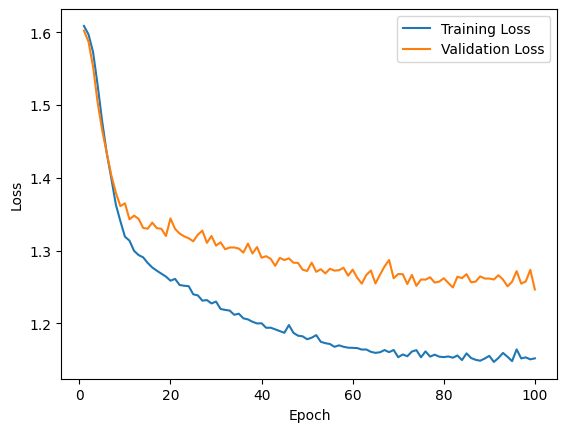

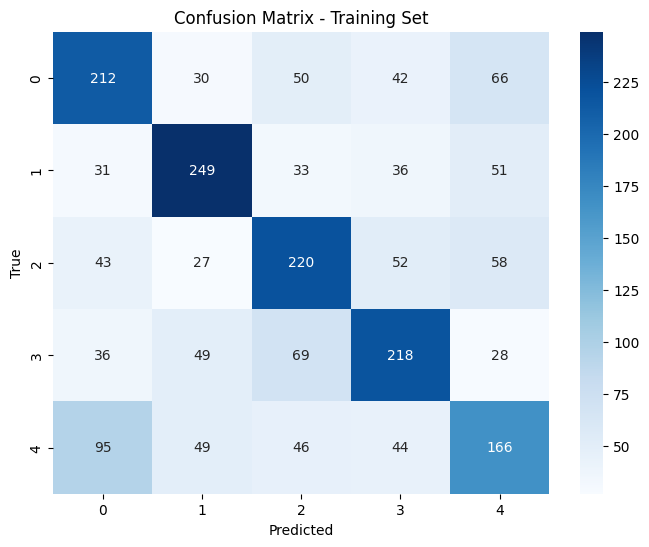

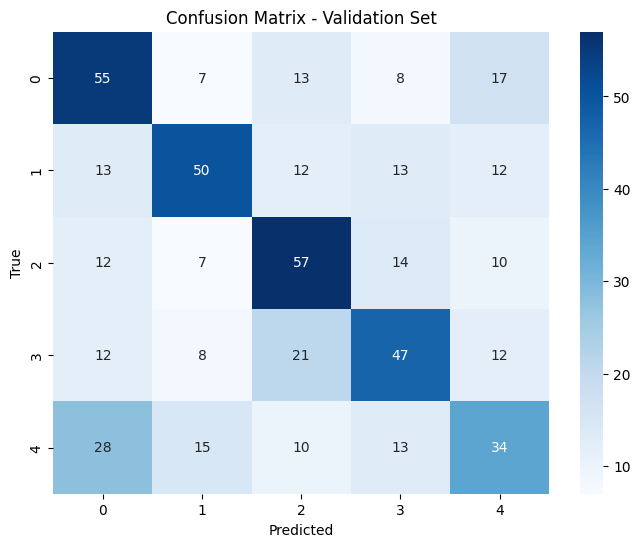


Training Model with Batch Normalization:
Epoch [1/100], Training Loss: 1.5811687499757796, Validation Loss: 1.4629001393914223
Epoch [2/100], Training Loss: 1.3812754835401262, Validation Loss: 1.353708989918232
Epoch [3/100], Training Loss: 1.2953278895408389, Validation Loss: 1.3114304319024086
Epoch [4/100], Training Loss: 1.2510817864584545, Validation Loss: 1.2681017443537712
Epoch [5/100], Training Loss: 1.2194944355222914, Validation Loss: 1.2625006958842278
Epoch [6/100], Training Loss: 1.1968433487982977, Validation Loss: 1.2497886717319489
Epoch [7/100], Training Loss: 1.1872922078011527, Validation Loss: 1.2487272694706917
Epoch [8/100], Training Loss: 1.1877737981932504, Validation Loss: 1.2505748942494392
Epoch [9/100], Training Loss: 1.1925856679204911, Validation Loss: 1.244271956384182
Epoch [10/100], Training Loss: 1.1785061094495985, Validation Loss: 1.2523800730705261
Epoch [11/100], Training Loss: 1.1807083799725486, Validation Loss: 1.2528751492500305
Epoch [12/10

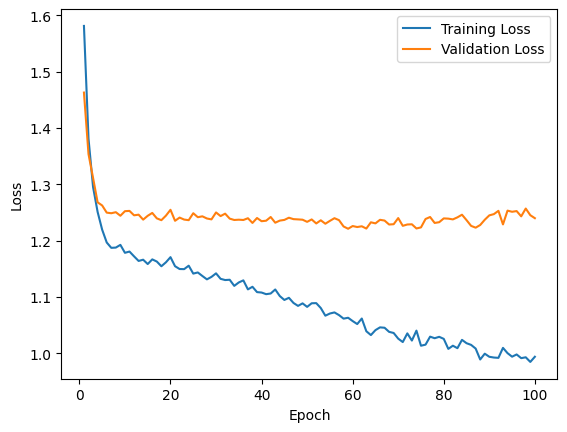

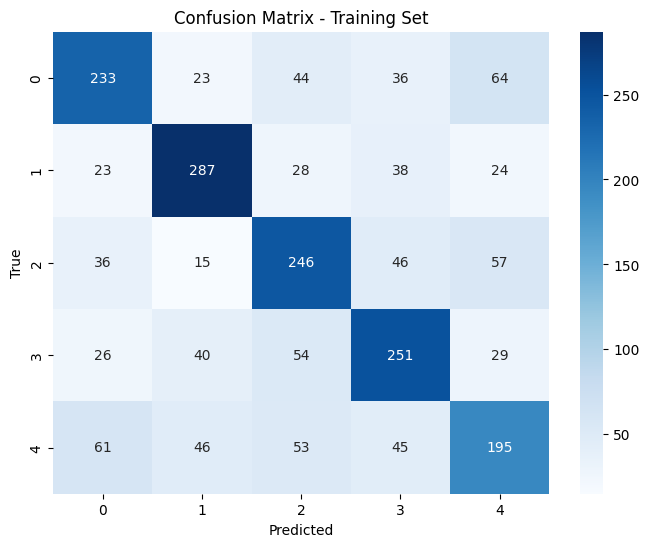

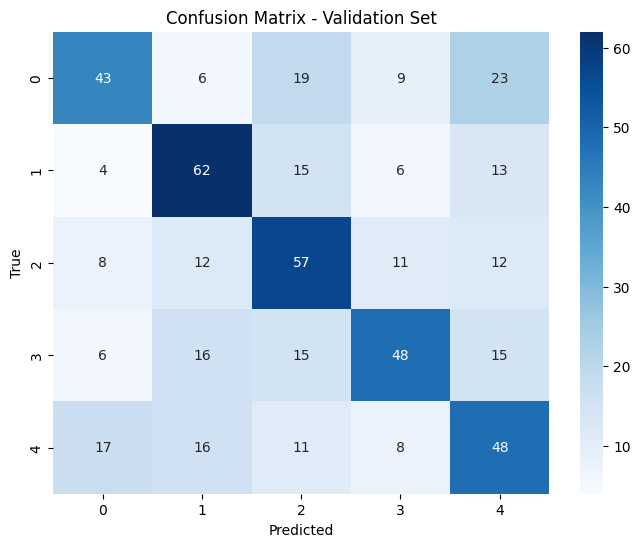

In [ ]:
# Training Model with No Normalization
print("Training Model with No Normalization:")
train_model(model_no_norm, criterion_no_norm, optimizer_no_norm, train_loader, val_loader, num_epochs, threshold)

# Training Model with Batch Normalization
print("\nTraining Model with Batch Normalization:")
train_model(model_batch_norm, criterion_batch_norm, optimizer_batch_norm, train_loader, val_loader, num_epochs, threshold)

In [ ]:
test_data2 = pd.read_csv("/content/test_data2.csv", header = None)
test_label2 = pd.read_csv("/content/test_label2.csv", header = None)

In [ ]:
test_data2.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.132358,0.108327,0.127412,0.138375,0.188309,0.110509,0.090077,0.083941,0.089655,0.140723,...,0.133242,0.141758,0.147963,0.166270,0.193717,0.207644,0.176183,0.149547,0.134927,0.138716
std,0.079282,0.078981,0.082828,0.081544,0.082320,0.079653,0.079167,0.077360,0.073697,0.081492,...,0.076212,0.082973,0.083567,0.082459,0.075363,0.080335,0.081954,0.085808,0.082637,0.080752
min,0.000000,0.000000,0.000000,0.000178,0.002442,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006101,0.002335,0.000000,0.000000,0.000000,0.000000
25%,0.064862,0.044152,0.061166,0.071069,0.121060,0.045715,0.028902,0.023008,0.031299,0.069304,...,0.070388,0.070598,0.081452,0.096301,0.135147,0.146594,0.106616,0.079973,0.067148,0.074016
50%,0.131070,0.096305,0.110832,0.125976,0.210153,0.091010,0.068777,0.062449,0.072508,0.133667,...,0.122431,0.137099,0.140609,0.167755,0.215794,0.233017,0.181139,0.143599,0.121291,0.130459
75%,0.198313,0.161188,0.194429,0.210204,0.251320,0.160485,0.128755,0.126504,0.131412,0.220058,...,0.188204,0.208897,0.215590,0.242487,0.252979,0.261618,0.244723,0.226329,0.198505,0.207736
max,0.299344,0.366867,0.319116,0.320494,0.471988,0.367548,0.332356,0.332356,0.292650,0.318715,...,0.325737,0.393509,0.393509,0.337104,0.337594,0.508743,0.352759,0.345134,0.353559,0.353559


In [ ]:
test_label2.value_counts()

0.0    100
1.0    100
2.0    100
3.0    100
4.0    100
dtype: int64


Evaluating Model with No Normalization on Test Set:
Final Test Loss: 1.257555477321148


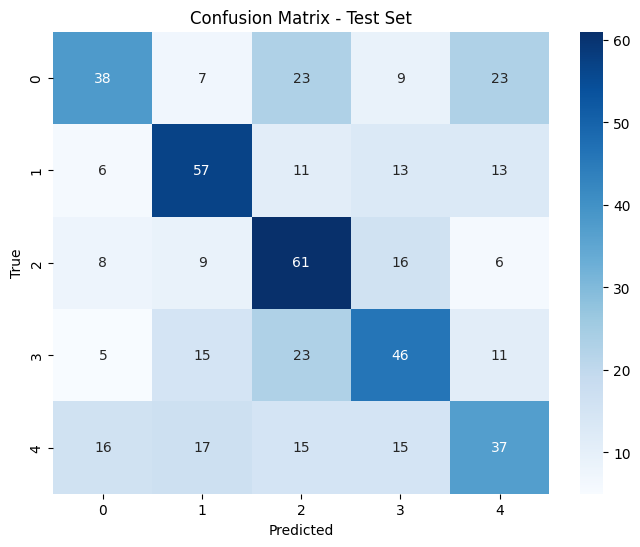


Evaluating Model with Batch Normalization on Test Set:
Final Test Loss: 1.236087117344141


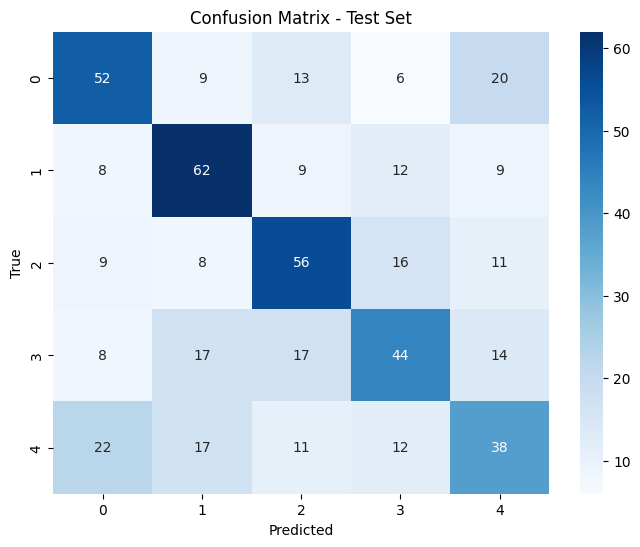

In [ ]:
X_test = val_data2.values.astype(np.float32)
y_test = val_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Function to evaluate the model on the test set and generate results
def evaluate_model(model, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_outputs = model(test_inputs)
            total_loss += criterion(test_outputs, test_labels).item()

            # Collect predictions and true labels for the test set
            _, test_preds = torch.max(test_outputs, 1)
            all_test_preds.extend(test_preds.cpu().numpy())
            all_test_labels.extend(test_labels.cpu().numpy())

    average_test_loss = total_loss / len(test_loader)
    print(f'Final Test Loss: {average_test_loss}')

    # Plot confusion matrix for test set
    plot_confusion_matrix(all_test_labels, all_test_preds, title='Confusion Matrix - Test Set')

# Evaluate Model with No Normalization on Test Set
print("\nEvaluating Model with No Normalization on Test Set:")
evaluate_model(model_no_norm, criterion_no_norm, test_loader)

# Evaluate Model with Batch Normalization on Test Set
print("\nEvaluating Model with Batch Normalization on Test Set:")
evaluate_model(model_batch_norm, criterion_batch_norm, test_loader)

In [ ]:
def train_model2(model, train_data2, criterion, optimizer, train_loader, val_loader, batch_size, hs1, hs2, learning_rate, num_epochs=100, threshold=1e-5, mode = ""):
    train_losses = []
    val_losses = []
    net_acc_sum = 0
    for epoch in range(num_epochs):
        total_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        model.train()  # Set the model to training mode
        batched_data = LabelledUniformLoader(train_data2, batch_size)
        #for inputs, labels in train_loader:
        for inputs, labels in batched_data:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, train_preds = torch.max(outputs, 1)
            all_train_preds.extend(train_preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)

        acc = 0
        # Validation loss
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                _, val_preds = torch.max(val_outputs, 1)
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(val_labels.cpu().numpy())
                acc += (val_preds == val_labels).sum().item()

        average_val_loss = val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        net_acc_sum += acc/len(val_loader.dataset)*100

        if(epoch == num_epochs-1):
          #print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}, Validation Loss: {average_val_loss}')
          print(epoch+1, average_loss, average_val_loss)
          print("Val Accuracy", net_acc_sum/(epoch+1))
          break


        # Check stopping criterion
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < threshold:
            #print(f'Stopping criterion met. Training stopped at epoch {epoch + 1}.')
            #print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}, Validation Loss: {average_val_loss}')
            print(epoch+1, average_loss, average_val_loss)
            print("Val Accuracy", net_acc_sum/(epoch+1))
            break

    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title("Average training and validation loss vs Epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.show()

    # Specify the path where you want to save the plot
    save_path = f"/content/plots2/error/{mode}_bs{batch_size}_h{hs1}_{hs2}_lr{learning_rate}_th{threshold}.png"  # Replace with your desired path and file name

    # Save the plot without displaying it
    plt.savefig(save_path)

    # Optional: Close the figure if you don't want to display it in the notebook
    plt.close()

    save_path_train = f"/content/plots2/confusion_matrix/train/cm_train_{mode}_bs{batch_size}_h{hs1}_{hs2}_lr{learning_rate}_th{threshold}.png"
    save_path_val = f"/content/plots2/confusion_matrix/val/cm_val_{mode}_bs{batch_size}_h{hs1}_{hs2}_lr{learning_rate}_th{threshold}.png"

    plot_confusion_matrix2(all_train_labels, all_train_preds, 'Confusion Matrix - Training Set', save_path_train)

    # Plot confusion matrix for validation set
    plot_confusion_matrix2(all_val_labels, all_val_preds, 'Confusion Matrix - Validation Set', save_path_val)

In [ ]:
X_train = train_data2.values.astype(np.float32)
y_train = train_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val = val_data2.values.astype(np.float32)
y_val = val_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test = val_data2.values.astype(np.float32)
y_test = val_label2.values.flatten().astype(np.int64)

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
def Grid_search():

  latex_file_path = "/content/latex.txt"
  with open(latex_file_path, "w"):
    pass #this effectively erases the contents of the latex.txt file

  bs_list = [32, 64, 128]
  lr_list = [0.01, 0.001]
  #h_list = [8, 16, 32]
  h_list = [[60, 30], [16, 16], [32, 32]]
  thresh_list = [1e-4, 5e-4]

  for batch_size in bs_list:
    torch.manual_seed(42)

    # Create DataLoader for training set
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for training set
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for test set
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    for hs in h_list:

      input_size = 36
      output_size = 5
      hs1 = hs[0]
      hs2 = hs[1]

      for learning_rate in lr_list:

        for threshold in thresh_list:

          torch.manual_seed(42)
          model_no_norm = MLFFNNNoNorm(input_size, hs1, hs2, output_size)
          criterion_no_norm = nn.CrossEntropyLoss()
          optimizer_no_norm = optim.Adam(model_no_norm.parameters(), lr=learning_rate)

          # Batch normalization
          model_batch_norm = MLFFNNBatchNorm(input_size, hs1, hs2, output_size)
          criterion_batch_norm = nn.CrossEntropyLoss()
          optimizer_batch_norm = optim.Adam(model_batch_norm.parameters(), lr=learning_rate)

          initialize_shared_weights(model_no_norm, model_batch_norm)

          num_epochs = 1000

          # Training Model with No Normalization
          #print("Training Model with No Normalization:")
          train_model2(model_no_norm, criterion_no_norm, optimizer_no_norm, train_loader, val_loader, batch_size, hs1, hs2, learning_rate, num_epochs, threshold, "NoNorm")
          evaluate_model2(model_no_norm, criterion_no_norm, test_loader, batch_size, hs1, hs2, learning_rate, num_epochs, threshold, "NoNorm")
          print_latex("NoNorm", batch_size, hs1, hs2, learning_rate, threshold)


          # Training Model with Batch Normalization
          #print("\nTraining Model with Batch Normalization:")
          train_model2(model_batch_norm, criterion_batch_norm, optimizer_batch_norm, train_loader, val_loader, batch_size, hs1, hs2, learning_rate, num_epochs, threshold, "BatchNorm")
          evaluate_model2(model_batch_norm, criterion_batch_norm, test_loader, batch_size, hs1, hs2, learning_rate, num_epochs, threshold, "BatchNorm")
          print_latex("BatchNorm", batch_size, hs1, hs2, learning_rate, threshold)


In [ ]:
import os

main_directory = '/content/plots2'
subdirectories = ['error', 'confusion_matrix', 'confusion_matrix/train', 'confusion_matrix/test', 'confusion_matrix/val']

for subdirectory in subdirectories:
    path = os.path.join(main_directory, subdirectory)
    os.makedirs(path, exist_ok=True)

Grid_search()

In [ ]:
import shutil

folder_path = '/content/plots2'

zip_file_name = 'plots2'

shutil.make_archive(zip_file_name, 'zip', folder_path)

shutil.move(zip_file_name + '.zip', '/content/' + zip_file_name + '.zip')

## Uniform Dataloader

In [ ]:
def LabelledUniformLoader(data, batch_size):
  datapoints = len(data)
  num_batches = int(datapoints/batch_size)
  examples_from_each_class = int(150/num_batches)
  # data_batches = torch.empty((num_batches, examples_from_each_class))
  data_batches = [[] for _ in range(num_batches)]
  # labels_batches = [[] for _ in range(num_batches)]
  for i in range(0, 5):
    indices = list(range(i*150, (i+1)*150))
    random.shuffle(indices)
    indicator = 0
    for batch in range(num_batches):
      # k = i*examples_from_each_class
      for j in range(indicator, indicator+examples_from_each_class):
        data_batches[batch].append((torch.tensor(data.iloc[indices[j]].values, dtype=torch.float32), i))
        # k+=1
      indicator+=examples_from_each_class

  data_batched = []
  for i in range(num_batches):
    batch = data_batches[i]
    random.shuffle(batch)
    datas = [t[0] for t in batch]
    labels = [t[1] for t in batch]
    first_tensor = torch.stack(datas)
    second_tensor = torch.tensor(labels, dtype=torch.long)
    data_batched.append((first_tensor, second_tensor))
  return data_batched

## Task 3

In [ ]:
train_data_labelled = pd.read_csv("/content/gdrive/MyDrive/team7/task3/training_data_set_7_labeled.csv", header=None)
train_data_unlabelled = pd.read_csv("/content/gdrive/MyDrive/team7/task3/training_data_set_7_unlabeled.csv", header=None)
val_data = pd.read_csv("/content/gdrive/MyDrive/team7/task3/validation_data_set_7.csv", header=None)
test_data = pd.read_csv("/content/gdrive/MyDrive/team7/task3/testing_data_set_7.csv", header=None)
train_data_labelled_labels = train_data_labelled[train_data_labelled.columns[-1]]
train_data_labelled.drop(train_data_labelled.columns[-1], axis=1, inplace=True)
val_data_labels = val_data[val_data.columns[-1]]
val_data.drop(val_data.columns[-1], axis=1, inplace=True)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def estimate_bottleneck_dimension(raw_data):
    # Perform PCA on the raw data
    pca = PCA()
    pca.fit(raw_data)

    # Calculate the cumulative explained variance ratio
    cum_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Find the index where cumulative explained variance ratio crosses 95%
    idx = np.argmax(cum_variance_ratio >= 0.70) + 1

    return idx

# Example usage:
# raw_data is assumed to be your actual raw data
# Replace raw_data with your actual raw data
raw_data = train_data_labelled  # Example random raw data of shape (100, 100)

bottleneck_dimension = estimate_bottleneck_dimension(raw_data)
print("Estimated bottleneck dimension:", bottleneck_dimension)


Estimated bottleneck dimension: 12


70 - 12

75 - 14

80 - 17

85 - 20

90 - 25

95 - 30

In [ ]:
h1 = [34, 32]
b1 = [30, 28]
h2 = [26, 24]
b2 = [22, 20]
h3 = [18, 16]
b3 = [14, 12]
lr = [0.0001, 0.001, 0.01]
thresholds = [1e-6, 1e-5]
num_epochs = [100, 250, 500]

In [ ]:
batch_size = 30
torch.manual_seed(42)

# X_labelled_train = train_data_labelled.values.astype(np.float32)
# y_labelled_train = train_data_labelled_labels.values.flatten().astype(np.int64)
X_unlabelled_train = train_data_unlabelled.values.astype(np.float32)
# X_labelled_train_tensor = torch.tensor(X_labelled_train)
# y_labelled_train_tensor = torch.tensor(y_labelled_train, dtype=torch.long)
X_unlabelled_train_tensor = torch.tensor(X_unlabelled_train)
# train_labelled_dataset = TensorDataset(X_labelled_train_tensor, y_labelled_train_tensor)
# train_loader_labelled = DataLoader(train_labelled_dataset, batch_size=batch_size, shuffle=True)
train_unlabelled_dataset = TensorDataset(X_unlabelled_train_tensor)
train_loader_unlabelled = DataLoader(train_unlabelled_dataset, batch_size=batch_size, shuffle=True)

X_val = val_data.values.astype(np.float32)
y_val = val_data_labels.values.flatten().astype(np.int64)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, bottleneck_dim):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Linear(input_dim, hidden_dim)

    self.bottleneck = nn.Linear(hidden_dim, bottleneck_dim)

    self.decoder = nn.Linear(bottleneck_dim, hidden_dim)

    self.output = nn.Linear(hidden_dim, input_dim)

  def forward(self, x):
    encoded = self.encoder(x)
    encoded = nn.Tanh()(encoded)
    bt = self.bottleneck(encoded)
    decoded = self.decoder(bt)
    decoded = nn.Tanh()(decoded)
    out = self.output(decoded)
    return out

In [ ]:
# # Define three autoencoders with different configurations
# torch.manual_seed(42)
# autoencoder1 = Autoencoder(36, 32, 28)
# torch.manual_seed(42)
# autoencoder2 = Autoencoder(28, 24, 20)
# torch.manual_seed(42)
# autoencoder3 = Autoencoder(20, 16, 12)
# x2 = autoencoder1.state_dict()

In [ ]:
class DFNN(nn.Module):
  def __init__(self, input_dim, aann1, aann2, aann3, num_classes, h1, h2, h3):
    super(DFNN, self).__init__()
    W1 = aann1.bottleneck.weight.detach()
    W2 = aann2.encoder.weight.detach()

    W3 = aann2.bottleneck.weight.detach()
    W4 = aann3.encoder.weight.detach()

    self.h1 = nn.Linear(input_dim, h1)
    self.h1.weight = nn.Parameter(aann1.encoder.weight) # why not use detach here?
    self.h2 = nn.Linear(h1, h2)
    self.h2.weight = nn.Parameter(torch.matmul(W2, W1))
    self.h3 = nn.Linear(h2, h3)
    self.h3.weight = nn.Parameter(torch.matmul(W4, W3))
    self.out = nn.Linear(h3, num_classes)

    self.model = nn.Sequential(
        self.h1,
        nn.Tanh(),
        self.h2,
        nn.Tanh(),
        self.h3,
        nn.Tanh(),
        self.out
    )

  def forward(self, x):
    out = self.model(x)
    return out

In [ ]:
# torch.manual_seed(42)
# dfnn = DFNN(36, autoencoder1, autoencoder2, autoencoder3, 5, 32, 24, 16)
# optimizer = torch.optim.Adam(dfnn.parameters())
# loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, criterion, optimizer, train_data, val_loader, num_epochs=100, threshold=1e-5):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        model.train()  # Set the model to training mode
        batched_data = LabelledUniformLoader(train_data, 30)
        for (inputs, labels) in batched_data:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, train_preds = torch.max(outputs, 1)
            all_train_preds.extend(train_preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        average_loss = total_loss / len(train_data)
        train_losses.append(average_loss)

        # Validation loss
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            total_correct = 0
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_preds = torch.max(val_outputs, 1)
                total_correct += (val_preds == val_labels).sum().item()
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(val_labels.cpu().numpy())

        average_val_loss = val_loss / len(val_loader)
        val_acc = total_correct / len(val_loader.dataset)
        val_losses.append(average_val_loss)

        # print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}, Validation Loss: {average_val_loss}')

        # Check stopping criterion
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < threshold:
            print(f'Stopping criterion met. Training stopped at epoch {epoch + 1}.')
            return val_losses[-1], train_losses[-1], val_acc
            break

    return val_losses[-1], train_losses[-1], val_acc

    # plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    # plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

In [ ]:
# def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, threshold=1e-5):
#     train_losses = []
#     val_losses = []
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         all_train_preds = []
#         all_train_labels = []

#         model.train()  # Set the model to training mode
#         batched_data = LabelledUniformLoader(train_data_labelled, 30)
#         for inputs, labels datapoint in batched_data:
#             random.shuffle(inputs)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#             _, train_preds = torch.max(outputs, 1)
#             all_train_preds.extend(train_preds.cpu().numpy())
#             all_train_labels.extend(labels.cpu().numpy())

#         average_loss = total_loss / len(train_loader)
#         train_losses.append(average_loss)

#         # Validation loss
#         model.eval()  # Set the model to evaluation mode
#         val_loss = 0.0
#         all_val_preds = []
#         all_val_labels = []
#         with torch.no_grad():
#             for val_inputs, val_labels in val_loader:
#                 val_outputs = model(val_inputs)
#                 val_loss += criterion(val_outputs, val_labels).item()

#                 _, val_preds = torch.max(val_outputs, 1)
#                 all_val_preds.extend(val_preds.cpu().numpy())
#                 all_val_labels.extend(val_labels.cpu().numpy())

#         average_val_loss = val_loss / len(val_loader)
#         val_losses.append(average_val_loss)

#         # print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}, Validation Loss: {average_val_loss}')

#         # Check stopping criterion
#         if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < threshold:
#             print(f'Stopping criterion met. Training stopped at epoch {epoch + 1}.')
#             return val_losses[-1], train_losses[-1]
#             break

#     return val_losses[-1], train_losses[-1]

#     # plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
#     # plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
#     # plt.xlabel('Epoch')
#     # plt.ylabel('Loss')
#     # plt.legend()
#     # plt.show()

In [ ]:
# train_model(dfnn, loss_fn, optimizer, train_data_labelled, val_loader)

In [ ]:
def train_autoencoder(model, train_loader, optimizer, loss_fn, num_epochs):
  for epoch in range(num_epochs):
      model.train()
      for data in train_loader:  # Labels not needed for autoencoders
          data = data[0]
          # Forward pass
          reconstructed = model(data)
          loss = loss_fn(reconstructed, data)
          # Backward pass and update weights
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Print training progress (optional)
      # print(f'Epoch: [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f}')

In [ ]:
# optimizer = torch.optim.Adam(autoencoder1.parameters())

In [ ]:
# train_autoencoder(autoencoder1, train_loader_unlabelled, optimizer, nn.MSELoss(), 100)

In [ ]:
# autoencoder1_out = autoencoder1.encoder(X_unlabelled_train_tensor)
# autoencoder1_out = autoencoder1.bottleneck(autoencoder1_out).detach()
# autoencoder1_dataset = TensorDataset(autoencoder1_out)
# autoencoder1_loader = DataLoader(autoencoder1_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# optimizer = torch.optim.Adam(autoencoder2.parameters())

In [ ]:
# train_autoencoder(autoencoder2, autoencoder1_loader, optimizer, nn.MSELoss(), 100)

In [ ]:
# autoencoder2_out = autoencoder2.encoder(autoencoder1_out)
# autoencoder2_out = autoencoder2.bottleneck(autoencoder2_out).detach()
# autoencoder2_dataset = TensorDataset(autoencoder2_out)
# autoencoder2_loader = DataLoader(autoencoder2_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# optimizer = torch.optim.Adam(autoencoder3.parameters())

In [ ]:
# train_autoencoder(autoencoder3, autoencoder2_loader, optimizer, nn.MSELoss(), 100)

In [ ]:
# dfnn2 = DFNN(36, autoencoder1, autoencoder2, autoencoder3, 5, a1h, a2h, a3h)
# optimizer = torch.optim.Adam(dfnn2.parameters())

In [ ]:
# train_model(dfnn2, loss_fn, optimizer, train_loader_labelled, val_loader)

In [ ]:
results_df = pd.DataFrame({'h1' : [0], 'b1' : [0], 'h2' : [0], 'b2' : [0], 'h3' : [0], 'b3' : [0], 'lr' : [0], 'epochs' : [0], 'threshold' : [0], "val_acc_pre" :[0], "val_loss_pre" :[0], "train_loss_pre":[0], "val_acc" :[0], "val_loss" :[0], "train_loss":[0]})

In [ ]:
def grid_search_run(h1, b1, h2, b2, h3, b3, epochs, t, lrates, results_df):
  grid = itertools.product(h1, b1, h2, b2, h3, b3, epochs, t, lrates)
  grid_search_results = []
  best_loss = 1e9
  dfnn_loss_fn = nn.CrossEntropyLoss()
  i = 0
  for combination in grid:
    i+=1
    # if i<=55:
    #   continue
    a1h, a1b, a2h, a2b, a3h, a3b, num_epochs, threshold, lr = combination
    print(combination)
    torch.manual_seed(42)
    autoencoder1 = Autoencoder(36, a1h, a1b)
    torch.manual_seed(42)
    autoencoder2 = Autoencoder(a1b, a2h, a2b)
    torch.manual_seed(42)
    autoencoder3 = Autoencoder(a2b, a3h, a3b)
    torch.manual_seed(42)
    dfnn1 = DFNN(36, autoencoder1, autoencoder2, autoencoder3, 5, a1h, a2h, a3h)
    optimizer = torch.optim.Adam(dfnn1.parameters(), lr = lr)
    v_loss, t_loss, v_acc = train_model(dfnn1, dfnn_loss_fn, optimizer, train_data_labelled, val_loader, num_epochs, threshold)
    optimizer = torch.optim.Adam(autoencoder1.parameters())
    train_autoencoder(autoencoder1, train_loader_unlabelled, optimizer, nn.MSELoss(), 100)
    autoencoder1_out = autoencoder1.encoder(X_unlabelled_train_tensor)
    autoencoder1_out = autoencoder1.bottleneck(autoencoder1_out).detach()
    autoencoder1_dataset = TensorDataset(autoencoder1_out)
    autoencoder1_loader = DataLoader(autoencoder1_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(autoencoder2.parameters())
    train_autoencoder(autoencoder2, autoencoder1_loader, optimizer, nn.MSELoss(), 100)
    autoencoder2_out = autoencoder2.encoder(autoencoder1_out)
    autoencoder2_out = autoencoder2.bottleneck(autoencoder2_out).detach()
    autoencoder2_dataset = TensorDataset(autoencoder2_out)
    autoencoder2_loader = DataLoader(autoencoder2_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(autoencoder3.parameters())
    train_autoencoder(autoencoder3, autoencoder2_loader, optimizer, nn.MSELoss(), 100)
    torch.manual_seed(42)
    dfnn2 = DFNN(36, autoencoder1, autoencoder2, autoencoder3, 5, a1h, a2h, a3h)
    optimizer = torch.optim.Adam(dfnn2.parameters(), lr = lr)
    v_loss_pre, t_loss_pre, v_acc_pre = train_model(dfnn2, dfnn_loss_fn, optimizer, train_data_labelled, val_loader)

    if v_loss_pre < best_loss:
      best_loss = v_loss_pre
      grid_search_results = combination

    results = [a1h, a1b, a2h, a2b, a3h, a3b, lr, num_epochs, threshold, v_loss_pre, v_acc_pre, t_loss_pre, v_loss, v_acc, t_loss]
    results_df.loc[len(results_df)] = results

    print(f"For this combo, number {i}")
    print(f"pretrained - val_loss = {v_loss_pre}, train_loss = {t_loss_pre}, val_acc = {v_acc_pre}")
    print(f"no pretrain - val_loss = {v_loss}, train_loss = {t_loss}, val_acc = {v_acc}")
    print("----------------------------------------")

  print(grid_search_results)
  return results_df

In [ ]:
results = grid_search_run(h1, b1, h2, b2, h3, b3, num_epochs, thresholds, lr, results_df)

(34, 30, 26, 22, 18, 14, 100, 1e-06, 0.0001)
For this combo, number 1
pretrained - val_loss = 1.1252934137980144, train_loss = 0.03490261260668437, val_acc = 0.56
no pretrain - val_loss = 1.1482206053204007, train_loss = 0.0372955284913381, val_acc = 0.512
----------------------------------------
(34, 30, 26, 22, 18, 14, 100, 1e-06, 0.001)
Stopping criterion met. Training stopped at epoch 39.
For this combo, number 2
pretrained - val_loss = 1.1513289742999606, train_loss = 0.02942129182815552, val_acc = 0.548
no pretrain - val_loss = 1.2372588846418593, train_loss = 0.028525913953781127, val_acc = 0.544
----------------------------------------
(34, 30, 26, 22, 18, 14, 100, 1e-06, 0.01)
Stopping criterion met. Training stopped at epoch 90.
For this combo, number 3
pretrained - val_loss = 2.912485122680664, train_loss = 0.0028552348067363105, val_acc = 0.488
no pretrain - val_loss = 2.031580275959439, train_loss = 0.015586472789446512, val_acc = 0.492
------------------------------------

In [ ]:
results

,h1,b1,h2,b2,h3,b3,lr,epochs,threshold,val_acc_pre,val_loss_pre,train_loss_pre,val_acc,val_loss,train_loss
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.00000,0.000,0.000000,0.000000,0.000,0.000000
1,34.0,30.0,26.0,22.0,18.0,14.0,0.0001,100.0,0.000001,1.12868,0.572,0.035376,1.153673,0.516,0.037487


In [ ]:
results_df.to_csv("results_upto_55_runs.csv")